In [ ]:
import csv
import pandas as pd
from tabulate import tabulate
import numpy as np
import os
import colorcet as cc
import sys
import matplotlib.pyplot as plt


In [ ]:


sys.path.insert(0, 'src/')
from pOXA48_S1 import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## __SI:__ Antimicrobial resistance level and conjugation permissiveness shape plasmid distribution in clinical enterobacteria

### 2. Model parametrization

This notebook focuses on obtaining specific parameters for each bacterial strain used in our study, encompassing both plasmid-bearing and plasmid-free cells. We extract these parameters from experimental data of each strain grown in isolation. The parameters encapsulate elements of growth kinetics, drug susceptibility, and bacterial conjugation capabilities. The ultimate goal of this process is to obtain a robust set of parameters that can be used to accurately simulate the ecological dynamics of mixed co-cultures. By creating models that closely reflect the real-world dynamics of bacterial populations under various conditions, we aim to deepen our understanding of the interactions within these populations and the impacts of environmental stressors such as antibiotics.

In [ ]:



path='./'
figPath = path+'figures/'
envPath = path+'env/'
dataPath = path+'data/'

strains_subsetE = [1, 2, 6, 9, 11, 15, 18, 20, 21, 24]
strains_subsetK = [25, 26, 29, 34, 37, 38, 39, 41, 43, 45]

strains_subset = strains_subsetE + strains_subsetK

print("subset: ",strains_subset)

strains = ['C001', 'C002',  'C006',  'C011',  'C012',  'C021',  'C022',  'C031',  'C051',  'C063',  'C094',  'C107',  'C115',  'C131',  'C141',  'C201',  'C227',  'C232',  'C247',  'C261',  'C286',  'C290',  'C302',  'C309',  'C324',  'K037',  'K038',  'K087',  'K094',  'K112',  'K114',  'K125',  'K141',  'K168',  'K177',  'K200',  'K201',  'K209',  'K213',  'K216',  'K224',  'K225',  'K241',  'K248',  'K249',  'K253',  'K257',  'K275',  'K285',  'K300']
plasmids = ['WT','TC']

tot_strains = int(len(strains))
cmap_strains = cc.glasbey_light[:tot_strains]

blue = '#129FE4'
red = '#E9666F'


subset:  [1, 2, 6, 9, 11, 15, 18, 20, 21, 24, 25, 26, 29, 34, 37, 38, 39, 41, 43, 45]


## Experimental parameters

In [ ]:

B0 = 1e6 #Initial bacterial density
T = 24 #Duration of experimental season
S0 = 1 #Concentration of imiting resource
extinction_threshold=1 #Extinction threshold
alphas=[1e-10, 1e-12] #Antibiotic degradation rate

A_max=65536*2 #Maximum antibiotic concentrations=[32768, 256, 1024, 32]

expe_params = {
    'B0': B0, #Initial bacterial density
    'A_max': A_max, #Maximum drug concentration
    'alphas': np.array(alphas), #Antibiotic degradation rate
    'T': T,  # Length of experiment
    'S0': S0,  # Resource concentration
    'extinction_threshold': extinction_threshold,
}


## Growth-kinetic parameters

In a prior study, we used the Metropolis-Hastings Markov chain Monte Carlo (MCMC) method to estimate maximum likelihood estimates of growth parameters for our ecological model. This approach allowed us to characterize specific affinity ($V_{max}/K_m$) and resource conversion rate ($\rho$) for each strain, grown independently with or without plasmids. Through fitting the model to individual growth curves, we generated a parameter vector $\psi=(\rho, V_{max}/K_m)$ for each strain. We tested the model's robustness by considering different prior distributions (uniform, lognormal, beta, and gamma), which yielded consistent maximum likelihood estimates. Furthermore, by using a data cloning algorithm[ref], we confirmed the identifiability of our parameters, with the marginal posterior distribution consistently converging to the maximum likelihood estimate as the number of clones increased

In [ ]:

def import_model_params(filename, expe_params):
    """
    Read model parameters from a CSV file.

    The function reads parameters from a CSV file and stores them into a pandas DataFrame. It also assigns
    experimental parameters (expe_params) as metadata to the DataFrame.

    Parameters:
    filename: string
        The name of the CSV file to read from.
    expe_params: dict
        The dictionary containing experimental parameters to be assigned as metadata to the DataFrame.

    Returns:
    df: pandas DataFrame
        The DataFrame containing model parameters.
    """

    model_params = {
         "strain_name": [], "strain_color": [], "specie": [], "strain": [], "type": [],
       "PCN": [], "MIC": [], "conj_rate": [],   "VKm": [], "rho": [], "seg_rate":[], "kappa": []}

    # Open the CSV file
    with open(filename, 'r') as csvfile:
        # Use the csv reader
        csvreader = csv.reader(csvfile)

        # Ignore the header
        headers = next(csvreader)

        # Read each row: name	color	specie	strain	type	PCN	MIC	conj_rate	VKm	rho	seg_rate	Kappa
        for row in csvreader:
            model_params["strain_name"].append(row[1])
            model_params["strain_color"].append(row[2])
            model_params["specie"].append(row[3])
            model_params["strain"].append(row[4])
            model_params["type"].append(row[5])
            model_params["PCN"].append(float(row[6]) if row[6] else np.nan)
            model_params["MIC"].append(float(row[7]) if row[7] else np.nan)
            model_params["conj_rate"].append(float(row[8]) if row[8] else np.nan)
            model_params["VKm"].append(float(row[9]) if row[9] else np.nan)
            model_params["rho"].append(float(row[10]) if row[10] else np.nan)
            model_params["seg_rate"].append(float(row[11]) if row[11] else np.nan)
            model_params["kappa"].append(float(row[12]) if row[12] else np.nan)

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(model_params)

    # Assign the experimental parameters as metadata
    df.attrs = expe_params

    # Return the completed DataFrame
    return df


def export_model_params(model_params, filename):
    """
    Write model parameters to a CSV file.

    The function takes a dictionary of model parameters and exports them to a specified CSV file.

    Parameters:
    model_params: dict
        The dictionary containing model parameters.
    filename: string
        The name of the CSV file to write to.
    """
    num_strains = int(len(model_params['specie']) / 2)

    # Prepare the header
    headers = ["", "name", "color", "specie", "strain", "type",
                "PCN", "MIC", "conj_rate", "VKm", "rho","seg_rate", "kappa"]

    # Prepare the rows
    rows = []
    for i in range(2 * num_strains):
        name = model_params['strain_name'][i]
        color = model_params['strain_color'][i]
        specie = model_params['specie'][i]
        strain = model_params['strain'][i]
        ptype = model_params['type'][i]
        pcn = model_params['PCN'][i]
        mic = model_params['MIC'][i]
        conj = model_params['conj_rate'][i]
        VKm = model_params['VKm'][i]
        rho = model_params['rho'][i]
        seg = model_params['seg_rate'][i]
        kappa = model_params['kappa'][i]
        row = [f"{i+1}", name, color, specie, strain, ptype, pcn, mic, conj, VKm, rho, seg, kappa]
        rows.append(row)

    # Write to the CSV file
    with open(filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(headers)
        csvwriter.writerows(rows)
    print("Data exported to %s"%filename)

model_params = import_model_params("%smodel_params.csv"%(dataPath), expe_params)

In [ ]:

def display_model_params(model_params):
    """
    Display model parameters in a table format.

    The function takes a dictionary of model parameters and formats it into a table using the tabulate module.
    The table is then printed to the console. The parameters are organized by strain type, first plasmid-free,
    then plasmid-bearing.

    Parameters:
    model_params: dict
        The dictionary containing model parameters.
    """
    table = []
    num_strains=int(len(model_params['specie'])/2)
    for i in range(num_strains): #Plasmid-Free (TC)
        name = model_params['strain_name'][i]
        strain = model_params['strain'][i]
        specie = model_params['specie'][i]
        ptype = model_params['type'][i]
        pcn = model_params['PCN'][i]
        mic = model_params['MIC'][i]
        conj = model_params['conj_rate'][i]
        VKm = model_params['VKm'][i]
        rho = model_params['rho'][i]
        seg = model_params['seg_rate'][i]
        kappa = model_params['kappa'][i]
        row = [f"{i+1}", name, strain, specie,  ptype, pcn, mic, conj, VKm, rho, seg, kappa]
        table.append(row)

    for i in range(num_strains): #Plasmid-bearing (WT)
        name = model_params['strain_name'][i+num_strains]
        strain = model_params['strain'][i+num_strains]
        specie = model_params['specie'][i+num_strains]
        ptype = model_params['type'][i+num_strains]
        pcn = model_params['PCN'][i+num_strains]
        mic = model_params['MIC'][i+num_strains]
        conj = model_params['conj_rate'][i+num_strains]
        VKm = model_params['VKm'][i+num_strains]
        rho = model_params['rho'][i+num_strains]
        seg = model_params['seg_rate'][i+num_strains]
        kappa = model_params['kappa'][i+num_strains]
        row = [f"{num_strains+i+1}", name, strain, specie,  ptype, pcn, mic, conj, VKm, rho, seg, kappa]
        table.append(row)

    headers = ["", "name", "strain", "specie",  "type", "PCN", "MIC", "conj_rate", "VKm", "rho", "seg_rate",  "kappa"]
    print(tabulate(table, headers, tablefmt="fancy_grid"))

This function plots the model parameters related to bacterial growth - the resource conversion rate (rho) and specific affinity (VKm), for both plasmid-free (TC) and plasmid-bearing (WT) strains. This scatter plot provides a visual comparison of these parameters across different bacterial strains, giving insights into their growth characteristics and how they may influence the dynamics of the system.

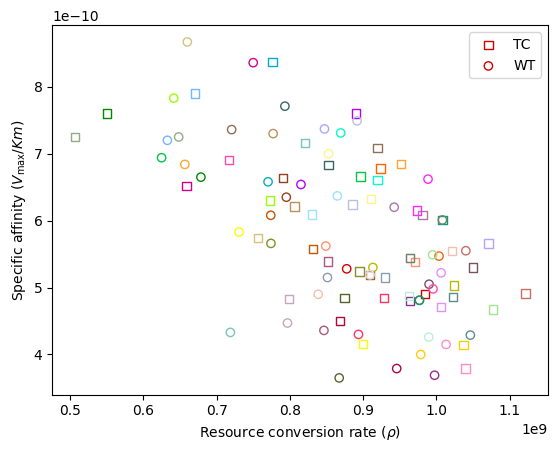

In [ ]:

def plot_growthParams(model_params):
    """
    Plot the resource conversion rate (rho) against the specific affinity (VKm) for all bacterial strains.

    This function creates a scatter plot, where each point represents a bacterial strain.
    The x-coordinate of the point corresponds to the strain's resource conversion rate (rho),
    and the y-coordinate corresponds to its specific affinity (VKm).
    The points corresponding to plasmid-free (TC) and plasmid-bearing (WT) strains are marked differently to distinguish between them.

    Parameters:
    model_params: dict
        The dictionary containing model parameters.
    """

    VKm_values = model_params['VKm']
    rho_values = model_params['rho']
    num_half = int(len(VKm_values)/2)

    # Create a scatter plot of VKm against rho
    plt.scatter(rho_values[:num_half], VKm_values[:num_half], marker='s', edgecolors=cmap_strains[:num_half], facecolors='none', label='TC')
    plt.scatter(rho_values[num_half:], VKm_values[num_half:], edgecolors=cmap_strains[:num_half], facecolors=cmap_strains[num_half:], label='WT')
    plt.xlabel(r'Resource conversion rate ($\rho$)')
    plt.ylabel(r'Specific affinity ($V_{\mathrm{max}}/Km$)')
    plt.legend()
    plt.show()

plot_growthParams(model_params)

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'facecolor'
  cset = contour_func(
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'facecolor'
  cset = contour_func(


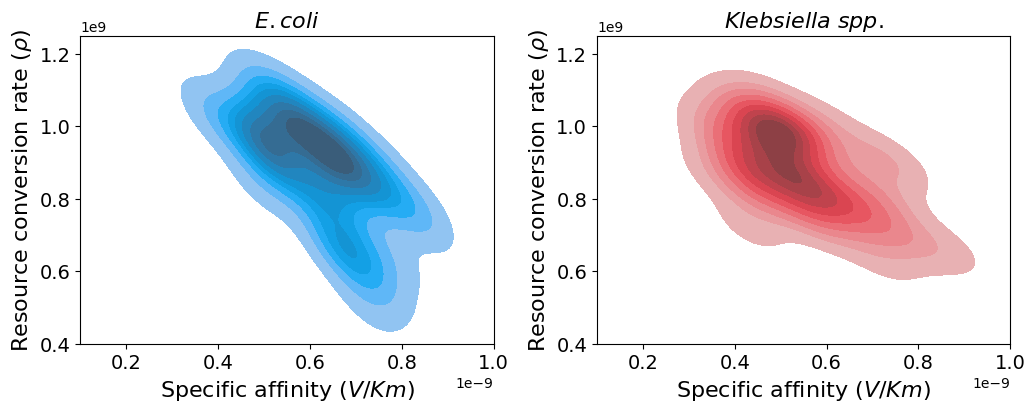

In [ ]:
import seaborn as sns

from sklearn.neighbors import KernelDensity
def plot_contour(model_params, species, fill_color):
    VKm_values = model_params['VKm']
    rho_values = model_params['rho']
    species_values = model_params['specie']

    # Filter data points based on the given species
    filtered_VKm = np.array(VKm_values)[np.array(species_values) == species]
    filtered_rho = np.array(rho_values)[np.array(species_values) == species]

    if len(filtered_VKm) == 0:
        print(f"No data points of species '{species}' found.")
        return

    # Create a grid of coordinates
    x_grid, y_grid = np.meshgrid(filtered_VKm, filtered_rho)

    # Combine VKm and rho values into a single array
    data = np.vstack([filtered_VKm, filtered_rho]).T

    # Fit kernel density estimation to the filtered data
    kde = KernelDensity(bandwidth=0.2)  # Adjust the bandwidth parameter as needed
    kde.fit(data)

    # Calculate density estimates for the grid points
    log_density = kde.score_samples(np.vstack([x_grid.ravel(), y_grid.ravel()]).T)
    density = np.exp(log_density)
    z_values = density.reshape(x_grid.shape)

    # KDE plot with custom fill color
    plt.subplot(1, 2, 1 if species == 'E' else 2)
    sns.kdeplot(data=data, x=filtered_VKm, y=filtered_rho, fill=True, facecolor=fill_color)
    plt.xlabel(r'Specific affinity ($V/Km$)', fontsize=16)
    plt.ylabel(r'Resource conversion rate ($\rho$)', fontsize=16)
    plt.xlim([0.1e-9, 1e-9])
    plt.ylim([0.4e9, 1.25e9])

    ax = plt.gca()  # Get the current axes
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    if species=='E':
      plt.title(r'$E. coli$', fontsize=16) #Kernel Density Estimation
    else:
      plt.title(r'$Klebsiella\,\,spp.$', fontsize=16) #Kernel Density Estimation


# Create a figure to contain the subplots
fig = plt.figure(figsize=(12, 4))

# Plot KDE plots for E and K species side-by-side with different fill colors
plot_contour(model_params, 'E', fill_color=blue)
plot_contour(model_params, 'K', fill_color=red)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.25)

# Show the plot
plt.show()



This function plots the resource uptake rate as a function of resource concentration for both plasmid-free (TC) and plasmid-bearing (WT) strains. The plot depicts the mean uptake rate for the TC and WT groups as well as individual uptake rates for strains within the specified istrains_values.

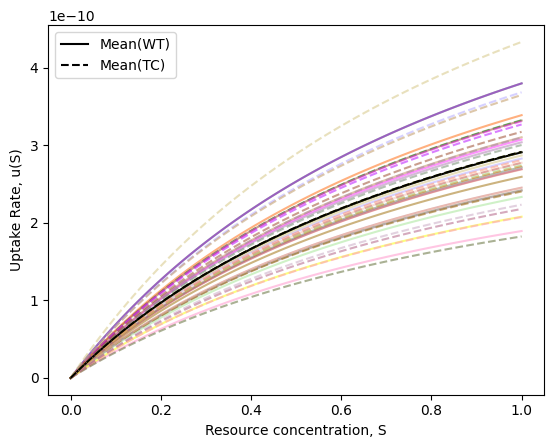

In [ ]:

def plot_uptake(istrains_values, S_values, VKm_values):
    """
    Plot the resource uptake rate (u(S)) as a function of resource concentration (S) for all bacterial strains.

    This function creates a plot where each line represents a bacterial strain.
    The x-coordinate corresponds to the resource concentration (S), and the y-coordinate corresponds to the uptake rate (u(S)).
    The lines corresponding to plasmid-free (TC) and plasmid-bearing (WT) strains are marked differently to distinguish between them.
    In addition to the individual strain lines, the plot also includes the mean uptake rate lines for the TC and WT groups.

    Parameters:
    istrains_values: list
        The indices of the strains to be included in the plot.
    S_values: list
        The resource concentration values.
    VKm_values: list
        The specific affinity (VKm) values for all bacterial strains.
    """
    num_strains = int(len(VKm_values)/2)
    cmap_strains = cc.glasbey_light[:num_strains]
    WT_growth_rates=[]
    for i in range(num_strains):
        growth_rates = [uS(S, VKm_values[i]) for S in S_values]
        if i in istrains_values:
          plt.plot(S_values, growth_rates, alpha=0.5, color=cmap_strains[i]) #, label=f'{codes[i+1]}'
        WT_growth_rates.append(growth_rates)

    WT_mean_growth_rates=np.mean(WT_growth_rates, axis=0)
    plt.plot(S_values, WT_mean_growth_rates, 'k-', label='Mean(WT)')

    TC_growth_rates=[]
    for i in range(num_strains):
        growth_rates = [uS(S, VKm_values[num_strains+i]) for S in S_values]
        if i in istrains_values:
          plt.plot(S_values, growth_rates, '--', alpha=0.5, color=cmap_strains[i]) #, label=f'{codes[i+1]}'
        TC_growth_rates.append(growth_rates)

    TC_mean_growth_rates=np.mean(TC_growth_rates, axis=0)
    plt.plot(S_values, TC_mean_growth_rates, 'k--', label='Mean(TC)')

    plt.xlabel('Resource concentration, S')
    plt.ylabel('Uptake Rate, u(S)')
    plt.legend()
    plt.show()


istrains_values = strains_subset #np.arange(len(strains_subset))
S_values = np.linspace(0, 1, 100)  # Example S values from 0 to 10
VKm_values = model_params['VKm']  # List of V values for each strain
plot_uptake(istrains_values, S_values, VKm_values)

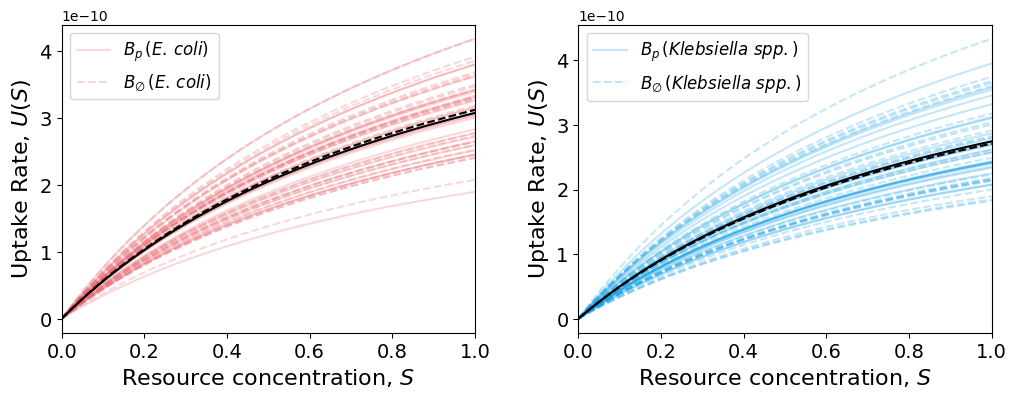

In [ ]:
def plot_uptake(istrains_values, S_values, VKm_values, subplot_index, color=[], label=''):
    num_strains = int(len(VKm_values)/2)
    cmap_strains = cc.glasbey_light[:num_strains]
    WT_growth_rates=[]
    for i in range(num_strains):
        growth_rates = [uS(S, VKm_values[i]) for S in S_values]
        plt.subplot(1, 2, subplot_index)
        if i in istrains_values:
            if i == istrains_values[0]:  # Only add the label for the first strain
                plt.plot(S_values, growth_rates, alpha=0.25, color=color, label=r'$B_p \,('+label+')$')
            else:
                plt.plot(S_values, growth_rates, alpha=0.25, color=color)
            WT_growth_rates.append(growth_rates)

    TC_growth_rates=[]
    for i in range(num_strains):
        growth_rates = [uS(S, VKm_values[num_strains+i]) for S in S_values]
        if i in istrains_values:
            if i == istrains_values[0]:  # Only add the label for the first strain
                plt.plot(S_values, growth_rates, '--', alpha=0.25, color=color, label=r'$B_\emptyset  \,('+label+')$')
            else:
                plt.plot(S_values, growth_rates, '--', alpha=0.25, color=color)
            TC_growth_rates.append(growth_rates)

    WT_mean_growth_rates = np.mean(WT_growth_rates, axis=0)
    plt.plot(S_values, WT_mean_growth_rates, 'k-')

    TC_mean_growth_rates = np.mean(TC_growth_rates, axis=0)
    plt.plot(S_values, TC_mean_growth_rates, 'k--')

    plt.xlabel(r'Resource concentration, $S$', fontsize=16)
    plt.ylabel(r'Uptake Rate, $U(S)$', fontsize=16)
    plt.xlim([0,1])
    plt.legend(fontsize=12)

    ax = plt.gca()  # Get the current axes
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)


fig = plt.figure(figsize=(12, 4))
istrains_values = range(25) #np.arange(len(strains_subset))
S_values = np.linspace(0, 1, 100)  # Example S values from 0 to 10
VKm_values = model_params['VKm']  # List of V values for each strain
plot_uptake(istrains_values, S_values, VKm_values, 1, color=red, label='E.\,coli')

istrains_values = range(25,50)
S_values = np.linspace(0, 1, 100)  # Example S values from 0 to 10
VKm_values = model_params['VKm']  # List of V values for each strain
plot_uptake(istrains_values, S_values, VKm_values, 2, color=blue, label='Klebsiella\,\,spp.' )

plt.subplots_adjust(wspace=0.25)
plt.show()


## Parametrizing Plasmid Segregation Rate
Upon bacterial cell division, plasmids need to segregate between the two daughter cells to maintain their presence in the population. However, this process isn't infallible, and sometimes a cell may divide without passing the plasmid to one of the offspring, resulting in what we call segregational loss.

The rate of segregational loss can depend on various factors. If plasmids were to segregate randomly upon division, we could model the segregational loss rate as a function of the Plasmid Copy Number (PCN) in the cell, using a formulation like seg_rate=1/2**(PCN-1).
However,, the plasmid we are examining in our model, pOXA-48, possesses an active partitioning system. This mechanism ensures a more balanced distribution of plasmids between daughter cells during division, thereby decreasing the segregational loss rate. Typically, plasmids with such a system have segregational loss rates in the range of 0.01 to 0.02.

In our model, we simplify by adopting a consistent segregational loss rate across all plasmid-host associations. Although this approximation might not capture every nuanced real-world scenario, it allows us to focus on the broader dynamics of plasmid propagation and antibiotic resistance within bacterial communities.

In [ ]:
def fit_seg_rates(model_params, strains_to_update):
    seg_rates = []
    for strain in strains_to_update:
        PCN = model_params.loc[strain, 'PCN']  # Get PCN value for the current strain
        seg_rate = 1 / 2 ** (PCN - 1)  # Calculate the new seg_rate based on PCN
        seg_rates.append(seg_rate)
    return seg_rates


def assign_strain_seg_rate(model_params, seg_rates=None, strains_to_update=None):
    if strains_to_update is None:
        strains_to_update = strains  # if no specific strains are specified, update all

    num_strains = len(strains_to_update)

    j = 0
    for i, strain in enumerate(strains):
      if i in strains_to_update:
        model_params.loc[i, 'seg_rate'] = seg_rates[j]
        j += 1


In [ ]:

#new_seg_rates = fit_seg_rates(model_params, strains_to_update)  # new seg_rate values for these strains

seg_rate=0.02
strains_to_update = np.arange(tot_strains)  # strains we want to update
new_seg_rates=seg_rate * np.ones(len(strains_to_update))
assign_strain_seg_rate(model_params, new_seg_rates, strains_to_update)




## Parametrizing the Rate of Horizontal Plasmid Transfer

Horizontal gene transfer (HGT) allows for the transfer of genetic material, such as the plasmids that confer antibiotic resistance, between distinct bacterial cells, and hence, between different bacterial strains. This exchange often occurs via a process known as conjugation.

An important aspect of our model is the assumption of mass action kinetics for the process of conjugation. This implies that the rate of plasmid transfer is proportional to the product of the densities of the donor and recipient populations. This is a reasonable assumption in a well-mixed environment where all individuals have an equal chance of encountering each other, and it greatly simplifies the mathematical description of the model.

In our model, we incorporate the rate of HGT, measured in conjugation events per donor cell per hour, by introducing a parameter that quantifies the propensity of a bacterial cell to accept a plasmid from another cell. This is what we refer to as permissiveness. By defining permissiveness, we acknowledge that not all bacterial cells are equally competent to receive and maintain foreign plasmids. This parameter, therefore, has the potential to significantly influence the overall dynamics of the bacterial community by modulating the spread of antibiotic resistance.

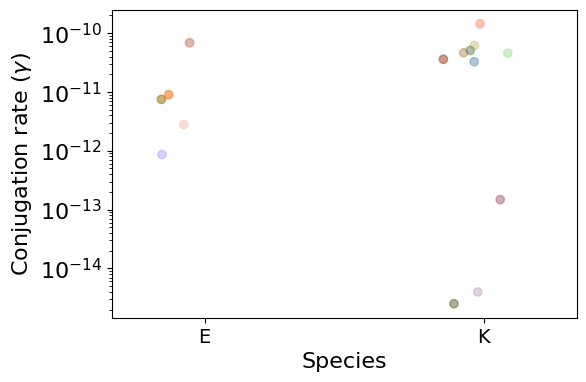

In [ ]:

def plot_conj_rate_scatter(model_params):
    """
    Generate a scatter plot displaying the conjugation rates of different bacterial species.

    The scatter plot is used to visualize the distribution of conjugation rates (γ) for different species of bacteria.
    The y-axis is displayed on a logarithmic scale to account for the large range of possible conjugation rates.

    Parameters:
    model_params: dict
        The parameters of the bacterial strains, including species, type, and conjugation rates.
    """

    df = pd.DataFrame(model_params)

    fig, ax = plt.subplots(figsize=(6, 4))

    # Filter data for each combination of 'specie' and 'type' and plot scatter points
    positions = [1.2, 1.8]
    species = ['E', 'K']
    types = ['WT']

    for i, specie in enumerate(species):
        for j, type_ in enumerate(types):
            specie_type_data = df[(df['specie'] == specie) & (df['type'] == type_)]

            # Calculate the jitter for scatter points
            jitter = np.random.uniform(low=-0.1, high=0.1, size=len(specie_type_data))

            # Calculate the x-position for scatter points
            x = positions[i * len(types) + j] + jitter

            # Set the color and alpha based on 'specie' and 'type'
            color = specie_type_data['strain_color']
            alpha = 0.5 if type_ == 'WT' else 0.5

            # Get the conj_rate values and handle NaN as 0
            conj_exponent = specie_type_data['conj_rate']
            conj_rate=10**conj_exponent

            # Get the strain names as labels
            #labels = specie_type_data['strain_name']

            # Plot the scatter points with y-axis in log2 scale
            ax.scatter(x, conj_rate, label=f'{specie} - {type_}', color=color, alpha=alpha)


    ax.set_xticks(positions)
    ax.set_xticklabels([f'{specie}' for specie in species for type_ in types], fontsize=14)
    ax.set_xlabel('Species', fontsize=16)
    ax.set_ylabel('Conjugation rate ($\gamma$)', fontsize=16)
    #ax.set_ylim([1e-8,5e-1])

    ax.set_xlim([1,2])

    ax.set_yscale('log', base=10)

    #ax.set_yticks(y_ticks)

    #
    #ax.yaxis.set_major_formatter(FixedFormatter([f'2^{i}' for i in range(17)]))

    ax.tick_params(axis='y', labelsize=16)


    #ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.02), title='Strain')

    # Show the plot
    plt.show()

plot_conj_rate_scatter(model_params)



---



In [ ]:
def get_selected_strains_params(model_params, istrains):
    num_strains = int(len(model_params['specie']) / 2)

    indices_tc = model_params.loc[(model_params.index.isin(istrains)) & (model_params['type'] == 'TC')].index
    indices_wt = indices_tc + num_strains

    output = pd.DataFrame()

    for key in model_params.columns:
        if key == 'type':
            output[key] = ['TC'] * len(indices_tc) + ['WT'] * len(indices_wt)
        else:
            output[key] = model_params.loc[indices_tc, key].tolist() + model_params.loc[indices_wt, key].tolist()

    output.attrs = model_params.attrs
    return output


In [ ]:
# This function plots the state variables of a simulation over time.
# It takes the time points (t) and state variables (ys) as input.
# The function plots the plasmid-bearing subpopulation, plasmid-free subpopulation,
# and total bacterial density as a function of time.
def plot_state(t, ys, color='black', show_legend=False, ax=None):
    if ax is None:
      fig, ax = plt.subplots()
    S = ys[0]
    B_TC = ys[2]
    B_WT = ys[3]
    B_sum = B_TC + B_WT

    # Plot plasmid-bearing subpopulation (solid line)
    ax.plot(t, B_TC.flatten(), '-', label='Plasmid-bearing', color=color)

    # Plot plasmid-free subpopulation (dotted line)
    ax.plot(t, B_WT.flatten(), ':', label='Plasmid-free', color=color)

    # Plot total bacterial density (black line)
    ax.plot(t, B_sum.flatten(), color='black', linewidth=2, label='Total')

    ax.set_xlabel('Time (hours)', fontsize=12)
    ax.set_ylabel('Density (cells/mL)', fontsize=12)
    if show_legend:
      ax.legend()

# Numerical simulations: Drug-response experiment

In [ ]:
def plot_DR_simulations(results, istrains, Amax_values):
    # Create subplots
    fig, axs = plt.subplots(1, len(results), figsize=(12, 2), sharey=True)

    for i, result in enumerate(results):
        # Unpack the simulation results
        times, ys, _, _, _, _ = result

        color=cmap_strains[istrains[0]]

        # Plot the simulation
        plot_state(times, ys, color=color, show_legend=False, ax=axs[i])
        axs[i].set_ylabel('')

        #axs[i].set_yscale('log')

        axs[i].set_xticks([0, 24])
        if i==0:
          axs[i].set_title(f'A={int(Amax_values[i])}', fontsize=12)
        else:
          axs[i].set_title(f'{int(Amax_values[i])}', fontsize=12)
          axs[i].set_xlabel('')


    # Set the common y-axis label
    fig.text(0.04, 0.5, 'Density (cells/mL)', va='center', rotation='vertical', fontsize=12)

    plt.show()

def plot_DR_BT(results, istrains, Amax_values, MIC=None, expe_MIC=None):

    extinction_threshold = model_params.attrs['extinction_threshold']

    if MIC is None:
      MIC = calculate_MIC(results, Amax_values)

    # Unpack final densities from results
    final_densities_pb = [result[3] for result in results]
    final_densities_pf = [result[4] for result in results]
    final_densities_total = [result[5] for result in results]

    # Plot Amax vs Density for plasmid-bearing subpopulation (colored solid line)
    plt.plot(Amax_values, final_densities_pb, color=cmap_strains[istrains[0]], linestyle='-',  label=r'$B_p$')

    # Plot Amax vs Density for plasmid-free subpopulation (colored dotted line)
    plt.plot(Amax_values, final_densities_pf, color=cmap_strains[istrains[0]], linestyle=':',  label=r'$B_\emptyset$')

    # Plot Amax vs Density for total bacterial population (solid black line)
    plt.plot(Amax_values, final_densities_total, color='black', marker='*', linestyle='-', label='$B_\emptyset$ + $B_p$')

    if expe_MIC is not None:
      plt.axvline(x=expe_MIC, color='#129FE4', linestyle=':')

    # Plot horizontal line at the extinction_threshold
    plt.axhline(y=extinction_threshold, color='gray', linestyle=':')

    # Plot a red dot at (MIC, extinction_threshold)
    if MIC is not None:
      plt.plot(MIC, extinction_threshold, 'ro')

    # Set labels and title
    plt.xlabel('Drug concentration', fontsize=16)
    plt.ylabel('Density at T=24 (cells/mL)', fontsize=16)

    # Set the x-axis to logarithmic scale, base 2
    plt.xscale('log', base=2)
    plt.xlim([2**0, 2**30])
    plt.yscale('log')
    plt.ylim([10**-2, 10**9])


    plt.legend()

    # Show the plot
    plt.show()




In [ ]:

def calculate_MIC(results, Amax_values):

    extinction_threshold = model_params.attrs['extinction_threshold']

    prev_final_total_density = None
    prev_Amax = None

    # Loop over the results for each antibiotic concentration
    for Amax, res in zip(Amax_values, results):
        # Extract the final total bacterial density
        final_total_density = res[-1].sum()

        # If the final total bacterial density is below the threshold, interpolate MIC
        if final_total_density < extinction_threshold:
            if prev_final_total_density is not None:
                # Linear interpolation formula in log space:
                # MIC = prev_Amax + (Amax - prev_Amax) * ((np.log(extinction_threshold) - np.log(prev_final_total_density)) / (np.log(final_total_density) - np.log(prev_final_total_density)))
                return prev_Amax + (Amax - prev_Amax) * ((np.log(extinction_threshold) - np.log(prev_final_total_density)) / (np.log(final_total_density) - np.log(prev_final_total_density)))
            else:
                return Amax

        prev_final_total_density = final_total_density
        prev_Amax = Amax

    # If no MIC was found (i.e., the bacteria survived all tested concentrations), return None
    return None

<ipython-input-18-b5ff42233fe7>:41: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([0,60000])


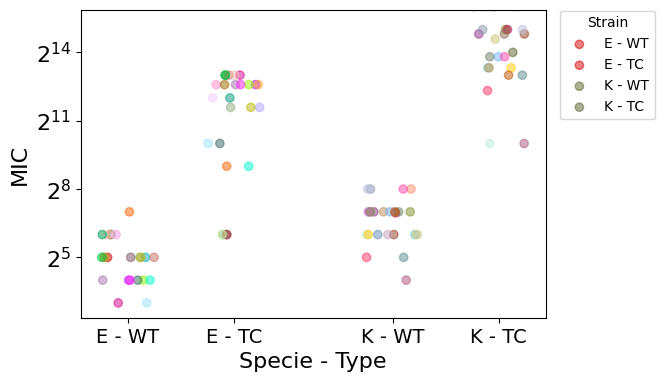

In [ ]:
from matplotlib.ticker import ScalarFormatter, LogLocator

def plot_expe_MIC_scatter(model_params):
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(model_params)

    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(6, 4))

    # Define the positions for scatter points
    positions = [0.8, 1.2, 1.8, 2.2]

    # Filter data for each combination of 'specie' and 'type' and plot scatter points
    species = ['E', 'K']
    types = ['WT', 'TC']

    for i, specie in enumerate(species):
        for j, type_ in enumerate(types):
            specie_type_data = df[(df['specie'] == specie) & (df['type'] == type_)]

            # Calculate the jitter for scatter points
            jitter = np.random.uniform(low=-0.1, high=0.1, size=len(specie_type_data))

            # Calculate the x-position for scatter points
            x = positions[i * len(types) + j] + jitter

            # Set the color and alpha based on 'specie' and 'type'
            color = specie_type_data['strain_color']
            alpha = 0.5 if type_ == 'WT' else 0.5

            # Plot the scatter points with y-axis in log2 scale
            ax.scatter(x, specie_type_data['MIC'], label=f'{specie} - {type_}', color=color, alpha=alpha)

    ax.set_xticks(positions)
    ax.set_xticklabels([f'{specie} - {type_}' for specie in species for type_ in types], fontsize=14)
    ax.set_xlabel('Specie - Type', fontsize=16)
    ax.set_ylabel('MIC', fontsize=16)

    # Set the y-axis to log2 scale
    ax.set_yscale('log', base=2)
    ax.set_ylim([0,60000])
    ax.tick_params(axis='y', labelsize=16)
    ax.yaxis.set_major_locator(LogLocator(base=2))
    ax.yaxis.set_minor_locator(LogLocator(base=2, subs=np.arange(0.1, 1.0, 0.1), numticks=10))

    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.02), title='Strain')

    # Show the plot
    plt.show()

# Example usage
plot_expe_MIC_scatter(model_params)


In [ ]:

from scipy.optimize import minimize

def fit_DR1(Amax_values, istrains, kappas, strain_type='WT', toPlot=False):

    # Set type index based on strain_type
    itype = 1 if strain_type == 'WT' else 0

    def calculate_diff(kappa):
        # Set initial conditions
        iniB = np.zeros(2)
        iniB[itype] = model_params.attrs['B0']
        y0 = np.concatenate(([S0], [0], iniB))

        expe_MIC = model_params['MIC'][this_istrain + itype*tot_strains]

        sf = np.ones(2)
        sf[itype]=kappa
        if itype==0: #TC
          sf[1]=kappas[1]

        # Run the simulations and store the results
        Amax_results, results = simulate_DR(model_params, y0, [this_istrain], Amax_values, sf)
        model_MIC = calculate_MIC(results, Amax_results)

        return abs(model_MIC - expe_MIC)

    # initial guess for kappa
    kappa_init = 1./25000.

    # Use scipy's minimize function to find the best kappa
    result = minimize(calculate_diff, kappa_init, bounds=[(0, np.inf)])

    best_kappa = result.x
    print(">> Best kappa=%s"%best_kappa)


    # Rerun the model with the best kappa to get the output
    sf = np.ones(2)
    sf[itype]=best_kappa
    if itype==0: #TC
      sf[1]=kappas[1]

    # Set initial conditions
    iniB = np.zeros(2)
    iniB[itype] = model_params.attrs['B0']
    y0 = np.concatenate(([S0], [0], iniB))

    best_Amax_results, best_results = simulate_DR(model_params, y0, [this_istrain], Amax_values, sf)
    best_MIC = calculate_MIC(best_results, best_Amax_results)
    expe_MIC = model_params['MIC'][this_istrain + itype*tot_strains]
    final_totals=0 #tmp

    if toPlot:
      plot_DR_simulations(best_results, [this_istrain], best_Amax_results)
      plot_DR_BT(best_results, [this_istrain], best_Amax_results, best_MIC, expe_MIC)

    return Amax_values, final_totals, best_kappa

In [ ]:
def simulate_DR(model_params, y0, Amax_values, kappa=None):

    extinction_threshold = model_params.attrs['extinction_threshold']

    results = []
    Amax_results = []

    # Loop over the different Amax values
    for Amax in Amax_values:
        y0[1] = Amax  # initial antibiotic concentration

        # Run the simulation
        if kappa is not None:
            model_params.iloc[0, model_params.columns.get_loc('kappa')] = kappa[0]
            model_params.iloc[1, model_params.columns.get_loc('kappa')] = kappa[1]

            #model_params.loc[i+tot_strains, 'kappa'] = kappa[1]
            #model_params.loc[i, 'kappa'] = kappa[0]

        times, ys = simulate_model(model_params, y0)

        B_TC = ys[2]
        B_WT = ys[3]
        B_total = B_TC + B_WT

        #if Amax == Amax_values[-1]:
        #    print("\t", Amax, ">", B_total[-1])

        final_densities_pb = B_TC[-1]
        final_densities_pf = B_WT[-1]
        final_densities_total = B_total[-1]

        # Add results to list
        results.append((times, ys, model_params, final_densities_pb, final_densities_pf, final_densities_total))
        Amax_results.append(Amax)

        if final_densities_total<extinction_threshold/10:
          break

    return Amax_results, results


In [ ]:
def fit_DR(strain_params, Amax_values, this_strain, kappas, strain_type='WT', toPlot=False):
    # Set type index based on strain_type
    itype = 1 if strain_type == 'WT' else 0
    kappa_values_TC = kappas[:,0]
    kappa_values_WT = kappas[:,1]

    expe_MIC = None
    best_MIC = np.inf
    best_kappa = np.inf
    best_results = []
    best_Amax = []
    final_totals = []  # list to store final_densities_total for each Amax

    for this_kappa in zip(kappa_values_TC, kappa_values_WT):
        # Set initial conditions
        iniB = np.zeros(2)
        iniB[itype] = strain_params.attrs['B0']
        y0 = np.concatenate(([S0], [0], iniB))

        expe_MIC = strain_params['MIC'][itype]


        # Run the simulations and store the results
        Amax_results, results = simulate_DR(strain_params, y0, Amax_values, this_kappa)
        model_MIC = calculate_MIC(results, Amax_results)

        # Update best MIC and kappa factor if current model MIC is closer to experimental MIC
        if model_MIC is None:
            best_MIC = None
            print("\t***expe_MIC = %s\tmodel_MIC = %s\tkappa = %s ___" % (expe_MIC, model_MIC, this_kappa))
        else:
            if abs(model_MIC - expe_MIC) <= abs(best_MIC - expe_MIC):
                best_MIC = model_MIC
                best_kappa = this_kappa[itype]
                best_results = results
                best_Amax = Amax_results
                print("\t*expe_MIC = %s\tmodel_MIC = %s\tkappa = %s -> %s*" % (expe_MIC, model_MIC, this_kappa, best_kappa))
            else:
                print("\t**expe_MIC = %s\tmodel_MIC = %s\tkappa = %s" % (expe_MIC, model_MIC, this_kappa))
                break

        this_totals = []
        for ir, r in enumerate(results):
            this_totals.append(r[5])

        final_totals.append(this_totals)

    # Plot the final densities as a function of Amax
    if toPlot:
        plot_DR_simulations(best_results, [this_strain], best_Amax)
        plot_DR_BT(best_results, [this_strain], best_Amax, best_MIC, expe_MIC)

    return Amax_values, final_totals, best_kappa


In [ ]:


def fit_kappa(kappas, this_istrain, toPlot=False):
  #First WT then TC. This way TC also considers the parameters of the WT segregants
  types=['WT','TC']
  best_kappas=[]

  for i, this_type in enumerate(types):

    if i==0: #WT
      kappa_values = np.column_stack((np.ones_like(kappas), kappas))
    else: #TC (Adjust parameters of WT segregants)
      kappa_values = np.column_stack((kappas, best_kappa*np.ones_like(kappas)))

    expe_MIC = model_params['MIC'][this_istrain]
    this_name = model_params['strain_name'][this_istrain]
    #print("\n%s: %s [%s]"%(this_istrain, this_name, this_type))


    powers = np.arange(-1,30.0)  # array of powers of two exponents
    this_Amax=np.power(2, powers)  # calculate 2 raised to each exponent

    this_params=get_selected_strains_params(model_params, [this_istrain])
    Amax_values, final_totals, best_kappa = fit_DR(this_params, this_Amax, this_istrain, kappa_values, this_type, toPlot=toPlot)

    print("* best_kappa=%s"%best_kappa)
    best_kappas.append(best_kappa)


  return best_kappas

def assign_strain_kappa(model_params, kappa=None, strains_to_update=None):
    if strains_to_update is None:
        strains_to_update = strains  # if no specific strains are specified, update all

    num_strains=len(strains_to_update)

    j=0
    for i, strain in enumerate(strains):
      if i in strains_to_update:
        model_params.loc[i+tot_strains, 'kappa'] = kappa[j]
        model_params.loc[i, 'kappa'] = kappa[j+num_strains]

        j+=1




## Parametrization of Drug Resistance Parameter

A critical parameters in our model is the drug susceptibility parameter, denoted as $\kappa$. This parameter is a measure of a strain's inherent resistance to a given antibiotic, with higher values indicating increased resistance. In our model, drug susceptibility of each strain plays a crucial role in determining how antibiotic concentration impacts the growth and survival of bacterial populations. It also influences the dynamics of plasmid transfer as it can determine the selective advantage conferred by the plasmid in environments with varying antibiotic concentrations.

Experimentally, we can expose the population to increasing antibiotic concentrations to identify the lowest concentration of the antibiotic at which bacterial growth is effectively inhibited, a quantity referred to as the Minimum Inhibitory Concentration (MIC).
In our model, the parameter $\kappa$ is inferred by fitting in silico dose-response experiments to the MIC values obtained experimentally. By plotting the growth rate as a function of the drug concentration, we can generate a theoretical dose-response curve associated with each value of $\kappa$. We the perform a grid algorithm to identify $\kappa^*$, the parameter that best describes the experimental dose-response experiment.

Strain PF_EC07:
	*expe_MIC = 64.0	model_MIC = 6437.677020181439	kappa = (1.0, 0.0625) -> 0.0625*
	*expe_MIC = 64.0	model_MIC = 50.29435171732176	kappa = (1.0, 0.00048828125) -> 0.00048828125*


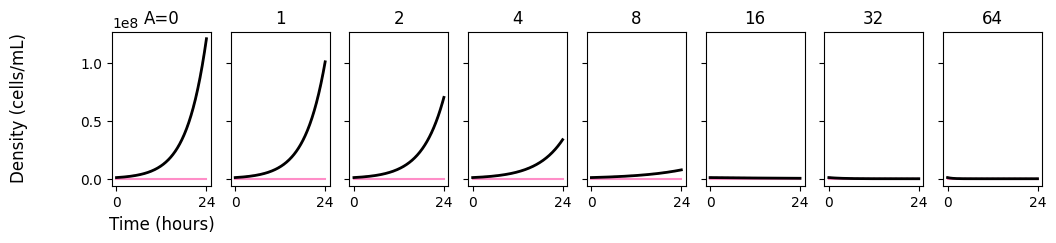

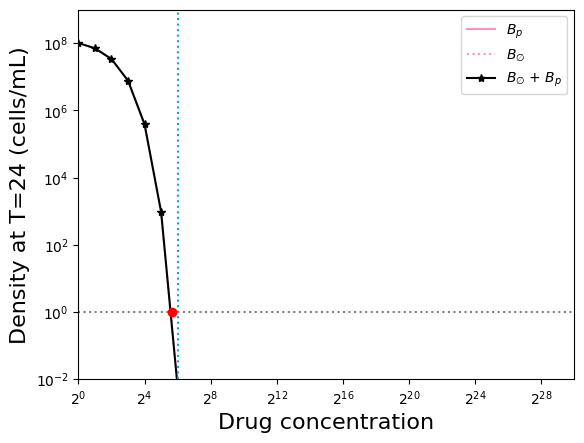

* best_kappa=0.00048828125
	*expe_MIC = 6144.0	model_MIC = 6330.258958496889	kappa = (0.0625, 0.00048828125) -> 0.0625*
	**expe_MIC = 6144.0	model_MIC = 49.73641343521879	kappa = (0.00048828125, 0.00048828125)


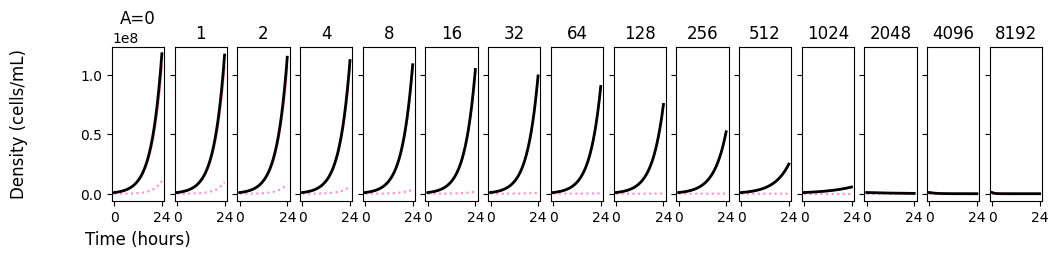

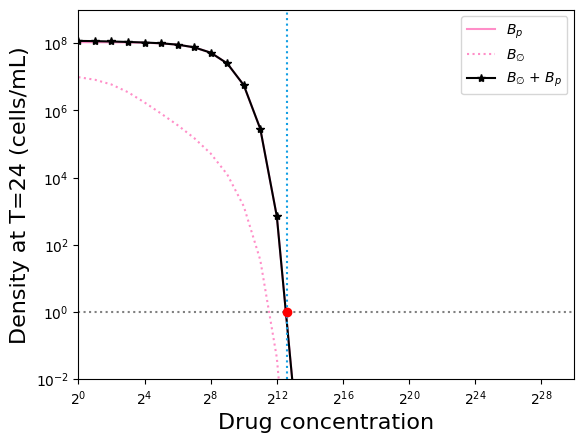

* best_kappa=0.0625


In [ ]:
toPlot=True
toFit=False


for this_istrain in [6]: #np.arange(0,tot_strains): #[6]: #np.arange(0,tot_strains): #strains_subset: #np.arange(0,tot_strains) #strains_subset
  print("Strain %s:"%model_params['strain_name'][this_istrain])
  #Perform data fitting
  if toFit:
    powers = np.arange(0.0,30.0)  # array of powers of two exponents
    kappas=1.0 / np.power(2.0, powers)
    #print(kappas)

    best_kappas=fit_kappa(kappas, this_istrain, toPlot)

    assign_strain_kappa(model_params, best_kappas, [this_istrain])
    export_model_params(model_params, "%smodel_params.csv"%(dataPath))
  else:

    powers = np.arange(0.,30.0)  # array of powers of two exponents
    kappas=[model_params['kappa'][this_istrain], model_params['kappa'][this_istrain+tot_strains]]
    fit_kappa(kappas, this_istrain, toPlot)


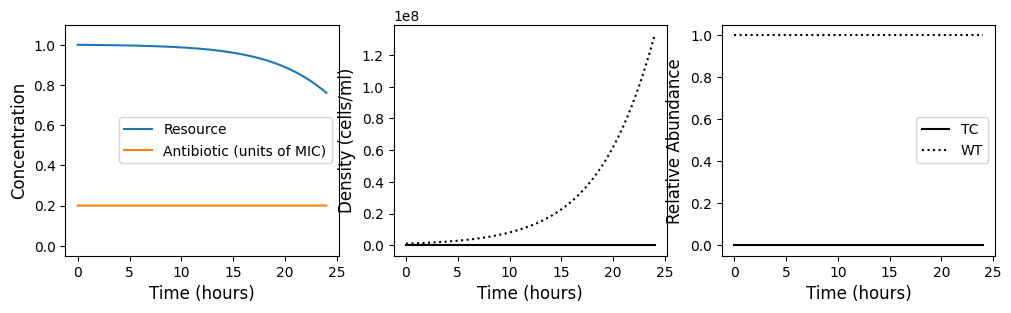

In [ ]:
# Run the simulation
A=0.2 #Environmental drug concentration
y0 = np.concatenate(([S0],[A], [0, B0]))
times, ys = simulate_model(model_params, y0)
plot_simulation(times, ys)

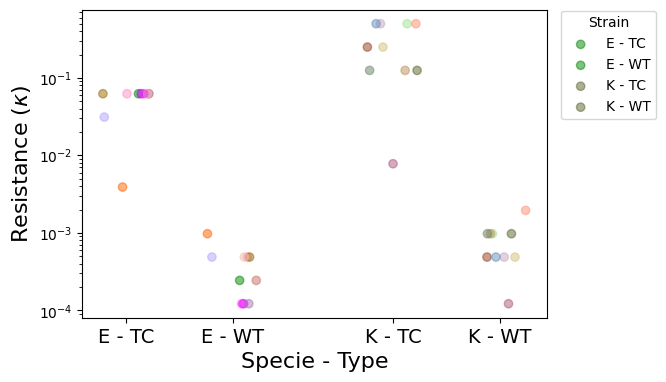

In [ ]:
def plot_kappa_scatter(model_params, istrains):
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(model_params)

    # Filter DataFrame based on istrains and istrains+tot_strains
    df = df[df.index.isin(np.concatenate([istrains, [i + tot_strains for i in istrains]]))]



    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(6, 4))

    # Define the positions for scatter points
    positions = [0.8, 1.2, 1.8, 2.2]

    # Filter data for each combination of 'specie' and 'type' and plot scatter points
    species = ['E', 'K']
    types = ['TC', 'WT']

    for i, specie in enumerate(species):
        for j, type_ in enumerate(types):
            specie_type_data = df[(df['specie'] == specie) & (df['type'] == type_)]

            # Calculate the jitter for scatter points
            jitter = np.random.uniform(low=-0.1, high=0.1, size=len(specie_type_data))

            # Calculate the x-position for scatter points
            x = positions[i * len(types) + j] + jitter

            # Set the color and alpha based on 'specie' and 'type'
            color = specie_type_data['strain_color']
            alpha = 0.5 if type_ == 'WT' else 0.5

            # Plot the scatter points with y-axis in log2 scale
            ax.scatter(x, specie_type_data['kappa'], label=f'{specie} - {type_}', color=color, alpha=alpha)

    ax.set_xticks(positions)
    ax.set_xticklabels([f'{specie} - {type_}' for specie in species for type_ in types], fontsize=14)
    ax.set_xlabel('Specie - Type', fontsize=16)
    ax.set_ylabel(r'Resistance ($\kappa$)', fontsize=16)

    # Set the y-axis to log2 scale
    ax.set_yscale('log')
    #ax.set_ylim([0,60000])
    #ax.tick_params(axis='y', labelsize=16)
    #ax.yaxis.set_major_locator(LogLocator(base=2))
    #ax.yaxis.set_minor_locator(LogLocator(base=2, subs=np.arange(0.1, 1.0, 0.1), numticks=10))

    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.02), title='Strain')

    # Show the plot
    plt.show()

plot_kappa_scatter(model_params, strains_subset)

In [ ]:

def display_model_params(model_params):
    table = []
    num_strains=int(len(model_params['specie'])/2)
    for i in range(num_strains): #Plasmid-Free (TC)
        name = model_params['strain_name'][i]
        color = model_params['strain_color'][i]
        specie = model_params['specie'][i]
        strain = model_params['strain'][i]
        ptype = model_params['type'][i]
        pcn = model_params['PCN'][i]
        mic = model_params['MIC'][i]
        conj = model_params['conj_rate'][i]
        VKm = model_params['VKm'][i]
        rho = model_params['rho'][i]
        seg = model_params['seg_rate'][i]
        kappa = model_params['kappa'][i]
        row = [f"{i+1}", name, color, specie, strain, ptype, pcn, mic, conj, VKm, rho, seg, kappa]
        table.append(row)

    for i in range(num_strains): #Plasmid-bearing (WT)
        name = model_params['strain_name'][i+num_strains]
        color = model_params['strain_color'][i+num_strains]
        specie = model_params['specie'][i+num_strains]
        strain = model_params['strain'][i+num_strains]
        ptype = model_params['type'][i+num_strains]
        pcn = model_params['PCN'][i+num_strains]
        mic = model_params['MIC'][i+num_strains]
        conj = model_params['conj_rate'][i+num_strains]
        VKm = model_params['VKm'][i+num_strains]
        rho = model_params['rho'][i+num_strains]
        seg = model_params['seg_rate'][i+num_strains]
        kappa = model_params['kappa'][i+num_strains]
        row = [f"{num_strains+i+1}", name, color, specie, strain, ptype, pcn, mic, conj, VKm, rho, seg, kappa]
        table.append(row)

    headers = ["", "name", "color","specie", "strain", "type", "PCN", "MIC", "conj_rate", "VKm", "rho", "seg_rate",  "kappa"]
    print(tabulate(table, headers, tablefmt="fancy_grid"))


display_model_params(model_params)

╒═════╤══════════╤═════════╤══════════╤══════════╤════════╤══════════╤═══════╤═════════════╤══════════╤═════════════╤════════════╤═════════════╕
│     │ name     │ color   │ specie   │ strain   │ type   │      PCN │   MIC │   conj_rate │      VKm │         rho │   seg_rate │       kappa │
╞═════╪══════════╪═════════╪══════════╪══════════╪════════╪══════════╪═══════╪═════════════╪══════════╪═════════════╪════════════╪═════════════╡
│   1 │ PF_EC01  │ #d60000 │ E        │ C001     │ TC     │   1.41   │    64 │    nan      │ 4.9e-10  │ 9.8441e+08  │       0.02 │ 0.000488281 │
├─────┼──────────┼─────────┼──────────┼──────────┼────────┼──────────┼───────┼─────────────┼──────────┼─────────────┼────────────┼─────────────┤
│   2 │ PF_EC02  │ #018700 │ E        │ C002     │ TC     │   1.3351 │  8192 │    nan      │ 7.6e-10  │ 5.50386e+08 │       0.02 │ 0.0625      │
├─────┼──────────┼─────────┼──────────┼──────────┼────────┼──────────┼───────┼─────────────┼──────────┼─────────────┼────────────┼

In [ ]:
def sci_notation(number):
    formatted_number = "{:.3e}".format(number)
    parts = formatted_number.split("e")
    base = parts[0]
    if len(parts) == 1:
        return base
    exponent = parts[1]
    return r"${} \times 10^{{{}}}$".format(base, exponent)



def display_model_params_latex(model_params, istrains=[]):
    """
    Display model parameters for selected bacterial strains in LaTeX tabular format.

    Parameters:
    model_params: dict
        The dictionary containing model parameters.
    istrains: list
        The list of indices of the strains to be displayed. If the list is empty, parameters for all strains are displayed.
    """
    num_strains = int(len(model_params['specie'])/2)

    if not istrains:
        istrains = list(range(num_strains))

    latex_code = r"\begin{tabular}{|c|c|c|c|c|c|c|c|c|}"
    latex_code += r"\hline"
    latex_code += "\n"
    latex_code += r"\textbf{Name} & \textbf{Specie} & \textbf{Type} & \textbf{PCN} & \textbf{MIC} & \textbf{Conjugation rate} & \textbf{Specific affinity} & \textbf{Resource conversion} & \textbf{Resistance coefficient} \\"
    latex_code += r"\hline"
    latex_code += "\n"

    for j in range(2):
      for i in istrains: #Plasmid-Free (TC) and Plasmid-bearing (WT)
            idx = i + num_strains*j
            name = model_params['strain_name'][idx].replace("_", "\\_")
            specie = model_params['specie'][idx]
            ptype = model_params['type'][idx]
            pcn = model_params['PCN'][idx]
            mic = model_params['MIC'][idx]
            conj = sci_notation(10**model_params['conj_rate'][idx])
            VKm = sci_notation(model_params['VKm'][idx])
            rho = sci_notation(model_params['rho'][idx])
            kappa = sci_notation(model_params['kappa'][idx])
            row = f"{name} & {specie} & {ptype} & {pcn} & {mic} & {conj} & {VKm} & {rho} & {kappa} \\\\"
            latex_code += row
            latex_code += r"\hline"
            latex_code += "\n"

    latex_code += r"\end{tabular}"

    print(latex_code)

#display_model_params_latex(model_params, strains_subset)
